In [1]:
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import scanpy as sc

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
import matplotlib_inline
import scib_metrics
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
np.random.seed(202310)

/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgp

In [2]:
adata = sc.read("/gpfs/gibbs/pi/zhao/wl545/pbmc/datasets/3k_test.h5ad")
adata.obs['Celltype'] = adata.obs['label'].copy() #refine cell type information by re-naming it.

In [5]:
def compute_embeddings(adata, path, mode):
    # with open("/gpfs/gibbs/pi/zhao/tl688/GenePT/data_embedding/GPT_3_5_gene_embeddings.pickle", "rb") as fp:
    #     GPT_3_5_gene_embeddings = pickle.load(fp)
    with open(path, "rb") as fp:
        GPT_3_5_gene_embeddings = pickle.load(fp)
    gene_names= list(adata.var.index)
    count_missing = 0
    EMBED_DIM = 1536 # embedding dim from GPT-3.5
    lookup_embed = np.zeros(shape=(len(gene_names),EMBED_DIM))
    for i, gene in enumerate(gene_names):
        if gene in GPT_3_5_gene_embeddings:
            lookup_embed[i,:] = GPT_3_5_gene_embeddings[gene].flatten()
        else:
            count_missing+=1
    print(f"Unable to match {count_missing} out of {len(gene_names)} genes in the GenePT-w embedding")
    
    genePT_w_emebed = None
    if mode == 'wa':
        genePT_w_emebed = adata.X / np.sum(adata.X, axis=1) [:,None]  @ lookup_embed
    if mode == 'aa':
        genePT_w_emebed = (adata.X @ lookup_embed) /len(gene_names)
    
    return genePT_w_emebed

In [8]:
scELMo_emebed_test = compute_embeddings(adata, 
                                          "/gpfs/gibbs/pi/zhao/tl688/GenePT/data_embedding/GPT_3_5_gene_embeddings.pickle",
                                          "wa")

Unable to match 51 out of 9334 genes in the GenePT-w embedding


In [9]:
def evaluate_nmi_ari(adata, label = 'scClassify', key='X_gpt3.5'):
    labels = np.array(list(adata.obs[label]))
    result1 = scib_metrics.nmi_ari_cluster_labels_leiden(adata.obsp['connectivities'], labels = labels, n_jobs = -1)
    result2 = scib_metrics.silhouette_label(adata.obsm[key], labels = labels, rescale=True, chunk_size=256)
    print(result1)
    print(result2)
    return result1, result2

In [10]:
adata.obsm['X_gpt3.5'] = scELMo_emebed_test

In [11]:
sc.pp.neighbors(adata, use_rep='X_gpt3.5')

In [12]:
evaluate_nmi_ari(adata, label = 'Celltype')

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


{'nmi': 0.6987137503910107, 'ari': 0.7489316462800611}
0.4971931055188179


({'nmi': 0.6987137503910107, 'ari': 0.7489316462800611}, 0.4971931055188179)

/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


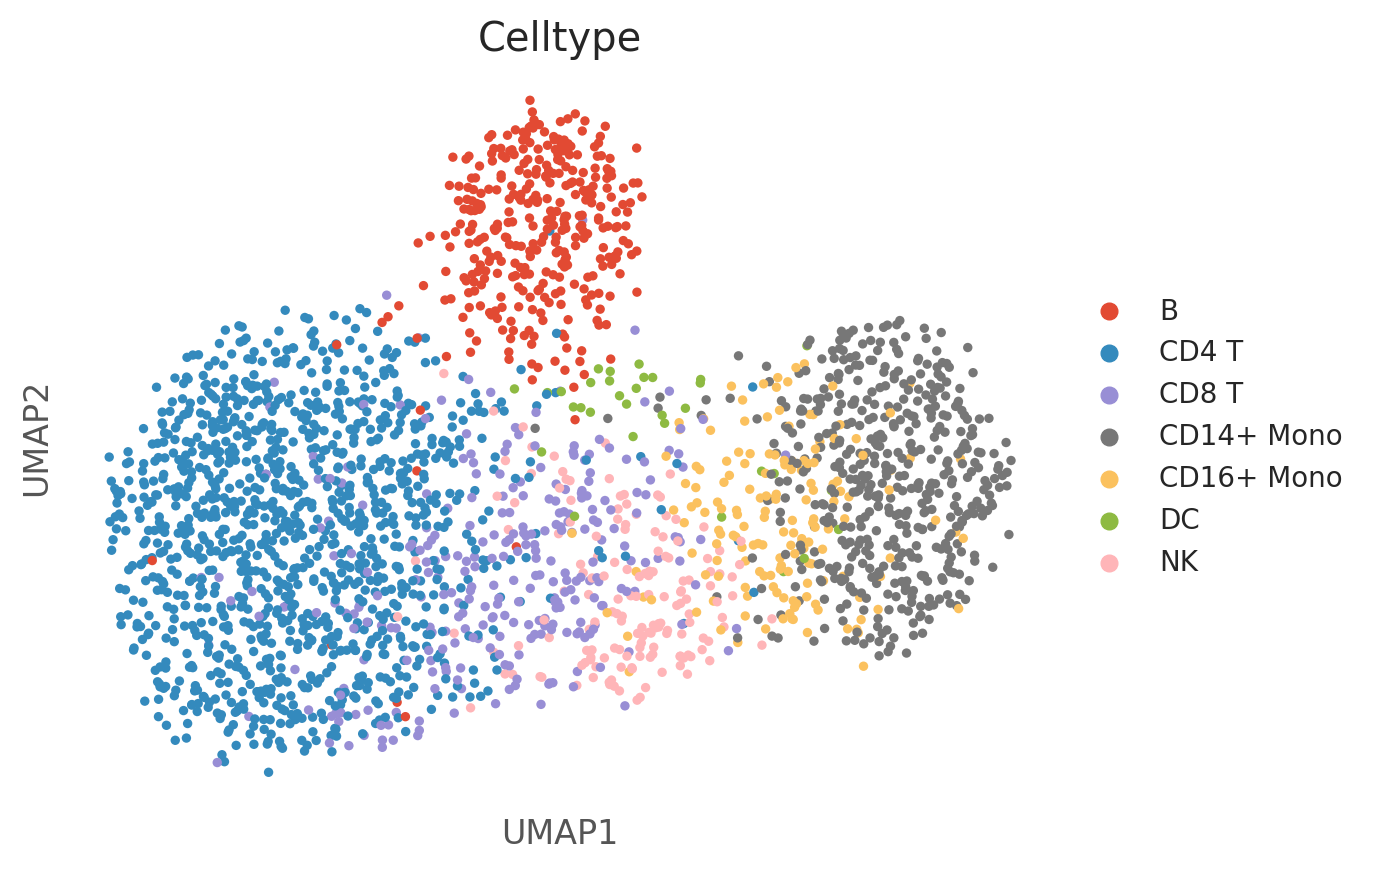

In [13]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='Celltype')